### Test Encoder

In [32]:
%run tf_helpers.py

filename = 'Solution/SiouxFalls/Output1/SiouxFall_UE_0'
stat = read_file(filename)
nodes = stat["data"]["nodes"]
path_link = stat['data']['paths_link']
path_flow  = stat['path_flow']
link_flow = {k: v for k,v in zip(range(76),stat['link_flow'])}
link_flow

{0: 10210.0,
 1: 14932.0,
 2: 8303.0,
 3: 13400.0,
 4: 20080.0,
 5: 21119.0,
 6: 26637.0,
 7: 30300.0,
 8: 23932.0,
 9: 11300.0,
 10: 26360.0,
 11: 14400.0,
 12: 23600.0,
 13: 14461.0,
 14: 14400.0,
 15: 17951.0,
 16: 20700.0,
 17: 22111.0,
 18: 22830.0,
 19: 15097.0,
 20: 8033.0,
 21: 9500.0,
 22: 26859.0,
 23: 4008.0,
 24: 26995.0,
 25: 27939.0,
 26: 13613.0,
 27: 19600.0,
 28: 14400.0,
 29: 4946.0,
 30: 13000.0,
 31: 15146.0,
 32: 13400.0,
 33: 14600.0,
 34: 19001.0,
 35: 11400.0,
 36: 21765.0,
 37: 20141.0,
 38: 16800.0,
 39: 15800.0,
 40: 14986.0,
 41: 3704.0,
 42: 18352.0,
 43: 14262.0,
 44: 21847.0,
 45: 20789.0,
 46: 11400.0,
 47: 15547.0,
 48: 14644.0,
 49: 15962.0,
 50: 7300.0,
 51: 17100.0,
 52: 9300.0,
 53: 30038.0,
 54: 16101.0,
 55: 28118.0,
 56: 17212.0,
 57: 11605.0,
 58: 13800.0,
 59: 33873.0,
 60: 11000.0,
 61: 11200.0,
 62: 11439.0,
 63: 11227.0,
 64: 12575.0,
 65: 15400.0,
 66: 22278.0,
 67: 12400.0,
 68: 7600.0,
 69: 14000.0,
 70: 12497.0,
 71: 16300.0,
 72: 11243.

In [50]:
def pair_link_adj(path_link, path_flow, link_flow, nodes):
    result = {}
    for i, (od_pair, paths) in enumerate(path_link.items()):
        if od_pair not in result:
            result[od_pair] = defaultdict(float)
        
        flows = path_flow[i]
        
        for path, flow in zip(paths, flows):
            for link_id in path:
                result[od_pair][link_id] += flow

    final_result = {od: dict(links) for od, links in result.items()}

    pair_link_adj = np.zeros((len(nodes), len(nodes), 76))
    for (o, d), value in final_result.items():
        for link, flow in value.items():
            pair_link_adj[o-1][d-1][link] = flow/link_flow[link]
    pair_link_adj = pair_link_adj.reshape(-1, 76)
    return pair_link_adj

In [51]:
pair_link = pair_link_adj(path_link, path_flow, link_flow, nodes)
pair_link = tf.convert_to_tensor(pair_link, dtype=tf.float32)

In [2]:
# print(torch.cuda.is_available())
import pandas as pd
%run tf_helpers.py
import tensorflow as tf

FOLDERS = [f'SiouxFalls/Output{i+1}' for i in range(3)]
files = load_files_from_folders(FOLDERS, max_files=20)
path_set_dict = path_encoder(files)

size = 64

X = []
Y = []
# X_Mask = []
# Y_Mask = []
Scalers = []
for i in tqdm(range(size)) :
    file_name = f"SiouxFalls/Output1/5by5_Data{i}"
    x, y, scaler = generate_xy(file_name, path_set_dict, test_set=True)
    X.append(x)
    Y.append(y)
    # X_Mask.append(xmask)
    # Y_Mask.append(ymask)
    Scalers.append(scaler)

X = tf.stack(X, axis=0)
Y = tf.stack(Y, axis=0)
# X_Mask = tf.stack(X_Mask, axis=0)
# Y_Mask = tf.stack(Y_Mask, axis=0)
print(X.shape, Y.shape)
print(len(Scalers))

  0%|          | 0/64 [00:00<?, ?it/s]

(64, 576, 6) (64, 576, 3)
64


In [ ]:
%run tf_attention.py
mha = MultiHeadAttention(6, 64, 8, 0.1)
out = mha(X, X, X, X_Mask)
out.shape

In [22]:
%run tf_attention.py

# enc = EncoderLayer(7, 64, 8, 0.1)
# out = enc(X, X_Mask)
# out.shape
encoder = Encoder(input_dim=7, d_model=64, N=4, heads=8, dropout=0.1)
encoder_output = encoder(X, X_Mask)
print(encoder_output.shape)
pd.DataFrame(encoder_output[0].numpy()).head()

(10, 625, 7)


,0,1,2,3,4,5,6
0,-1.673828,1.394531,0.241333,-0.524414,1.283203,-0.442139,-0.278076
1,0.583496,0.999512,1.054688,-1.752930,0.540527,-0.424072,-1.000977
2,-1.636719,-0.097961,-0.810547,0.438721,0.604004,-0.241333,1.743164
3,-1.866211,0.620117,-0.305176,-0.447998,1.610352,0.487305,-0.098511
4,-1.673828,1.394531,0.241333,-0.524414,1.283203,-0.442139,-0.278076


### Test Decoder

In [23]:
%run tf_attention.py

dec = DecoderLayer(3, 64, 8, 0.1)
out = dec(Y, encoder_output, X_Mask, Y_Mask)
out.shape

TensorShape([10, 625, 3])

In [26]:
%run tf_attention.py
decoder = Decoder(output_dim=3, d_model=64, N=2, heads=8, dropout=0.1)
decoder_out = decoder(Y,encoder_output, X_Mask, Y_Mask)
pd.DataFrame(decoder_out[0].numpy()).head()

,0,1,2
0,-0.158203,1.295898,-1.137695
1,0.797852,0.612305,-1.410156
2,1.392578,-0.483398,-0.909180
3,1.082031,0.247070,-1.329102
4,-0.158203,1.295898,-1.137695


### Test Transformer

In [28]:
%run tf_attention.py

transformer = Transformer(7,3,64,2,8,0.1)
transformer.train()
out = transformer(X, Y, X_Mask, Y_Mask)
pd.DataFrame(out[0].numpy()).head()

,0,1,2
0,0.756836,0.214355,0.540527
1,0.797363,0.271240,0.405762
2,0.803223,0.361328,0.302490
3,0.801758,0.294434,0.371582
4,0.756836,0.214355,0.540527


### Extract OD demand and path set (X and Y)
X: OD demand, graph (link feature), path, link-path adj \
Y: path flow

In [1]:
%run tf_attention.py
%run tf_helpers.py 
%run parameters.py
p = Params()

files = load_files_from_folders(FOLDERS, max_files=100)
path_set_dict = path_encoder(files)

class Dataset:
    def __init__(self, files):
        # self.path_encoded = path_encoder()  # Get path encode dictionary
        self.X = []
        self.Y = []
        self.X_mask = []
        self.Y_mask = []

        for file_name in tqdm(files):
            x, y, xMask, yMask = generate_xy(file_name, path_set_dict)
            self.X.append(x)
            self.Y.append(y)
            self.X_mask.append(xMask)
            self.Y_mask.append(yMask)
        
        self.X = tf.stack(self.X, axis=0)
        self.Y = tf.stack(self.Y, axis=0)
        self.X_mask = tf.stack(self.X_mask, axis=0)
        self.Y_mask = tf.stack(self.Y_mask, axis=0)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.X_mask[idx], self.Y_mask[idx]

    def to_tf_dataset(self, batch_size):
        dataset = tf.data.Dataset.from_tensor_slices((self.X, self.Y, self.X_mask, self.Y_mask))
        dataset = dataset.shuffle(buffer_size=len(self.X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

def get_test_set(files):
    X = []
    Y = []
    X_Mask = []
    Y_Mask = []
    Scalers = []
    for file_name in tqdm(files) :
        x, y, xmask, ymask, scaler = generate_xy(file_name, path_set_dict, test_set=True)
        X.append(x)
        Y.append(y)
        X_Mask.append(xmask)
        Y_Mask.append(ymask)
        Scalers.append(scaler)
    X = tf.stack(X, axis=0)
    Y = tf.stack(Y, axis=0)
    X_Mask = tf.stack(X_Mask, axis=0)
    Y_Mask = tf.stack(Y_Mask, axis=0)
    dataset = tf.data.Dataset.from_tensor_slices((X, Y, X_Mask, Y_Mask))
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset, Scalers

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6


In [2]:
# FOLDERS = [f'../Solution/Output{i+1}' for i in range(3)]
files = load_files_from_folders(FOLDERS, max_files=DATA_SIZE)
train_files, val_files, test_files = split_dataset(files, TRAIN_RATE, VAL_RATE)

train_dataset = Dataset(train_files)
train_data_loader = train_dataset.to_tf_dataset(BATCH_SIZE)

val_dataset = Dataset(val_files)
val_data_loader = train_dataset.to_tf_dataset(BATCH_SIZE)

test_dataset, scalers = get_test_set(test_files)

  0%|          | 0/1680 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

### TRY TRAINING AND VALIDATING

In [3]:
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
import time
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%run Parameters_old.py
%run tf_attention_old.py
%run tf_helpers_old.py 
p = Params()

model = Transformer(input_dim=p.input_dim, output_dim=p.output_dim,
                    d_model=p.d_model, E_layer=p.E_layer,
                    D_layer=p.D_layer, heads=p.heads, dropout=p.dropout)
optimizer = Adam(learning_rate=p.lr, clipvalue=1.0)

start = time.time()
trained_model, train_loss, val_loss = model.fit(train_data_loader, val_data_loader, optimizer, p.loss_fn, p.epochs, p.device)
end = time.time()
train_time = end-start

  0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch: 1 - Train Loss: 0.2639, Val Loss: 0.2539
Epoch: 2 - Train Loss: 0.2451, Val Loss: 0.2363
Epoch: 3 - Train Loss: 0.2276, Val Loss: 0.2190
Epoch: 4 - Train Loss: 0.2105, Val Loss: 0.2018
Epoch: 5 - Train Loss: 0.1937, Val Loss: 0.1854
Epoch: 6 - Train Loss: 0.1775, Val Loss: 0.1695
Epoch: 7 - Train Loss: 0.1619, Val Loss: 0.1544
Epoch: 8 - Train Loss: 0.1471, Val Loss: 0.1399
Epoch: 9 - Train Loss: 0.1332, Val Loss: 0.1266
Epoch: 10 - Train Loss: 0.1204, Val Loss: 0.1142
Epoch: 11 - Train Loss: 0.1086, Val Loss: 0.1030
Epoch: 12 - Train Loss: 0.0979, Val Loss: 0.0929
Epoch: 13 - Train Loss: 0.0883, Val Loss: 0.0839
Epoch: 14 - Train Loss: 0.0797, Val Loss: 0.0757
Epoch: 15 - Train Loss: 0.0721, Val Loss: 0.0686
Epoch: 16 - Train Loss: 0.0654, Val Loss: 0.0622
Epoch: 17 - Train Loss: 0.0612, Val Loss: 0.0567
Epoch: 18 - Train Loss: 0.0542, Val Loss: 0.0516
Epoch: 19 - Train Loss: 0.0495, Val Loss: 0.0473
Epoch: 20 - Train Loss: 0.0454, Val Loss: 0.0435
Epoch: 21 - Train Loss: 0.041

KeyboardInterrupt: 

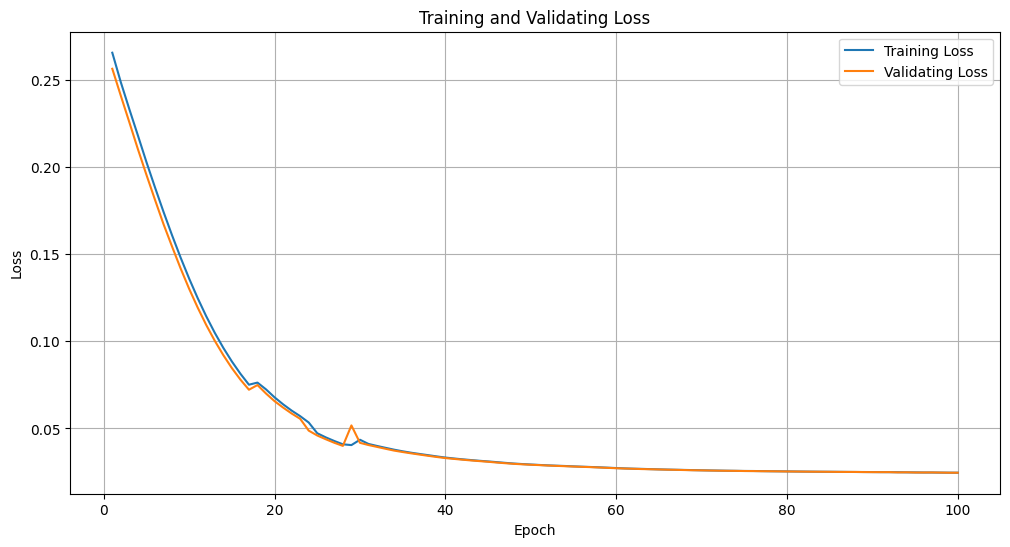

In [ ]:
plot_loss(train_loss, val_loss, p.epochs)

In [ ]:
pred_tensor = predict_withScaler(trained_model, test_dataset, scalers, p.device)

In [ ]:
i = 1
stat = read_file(files[i])
pred_df, len_origin, len_pred, nan_num = create_pred_df(pred_tensor[i], stat)
pred_link_flow = sum_pred_link_flow(pred_df, stat)
pred_df

,od,demand,path1,path2,path3,flow1,flow2,flow3
0,"(3, 24)",66,"(6, 10, 26, 40, 56)","(7, 22, 26, 40, 56)","(7, 23, 35, 40, 56)",4.500000,2.751953,2.072266
1,"(1, 2)",90,"(0,)","(1, 14, 16)","(1, 14, 18, 20, 5)",6.136719,3.751953,2.826172
2,"(6, 3)",62,"(13, 0, 3)","(14, 16, 3)","(14, 18, 20)",4.226562,2.583984,1.947266
3,"(6, 5)",72,"(13, 0, 3, 6, 9)","(14, 16, 3, 6, 9)","(14, 18, 20, 6, 9)",4.910156,3.001953,2.261719
4,"(7, 17)",241,"(18, 23, 36, 50)","(19, 33, 36, 50)","(18, 23, 35, 40, 54, 50)",16.437500,10.046875,7.566406
5,"(11, 20)",80,"(29, 14, 18, 22, 25, 28, 42)","(29, 14, 18, 23, 35, 39, 42)","(29, 14, 18, 22, 26, 39, 42)",5.453125,3.335938,2.511719
6,"(9, 8)",84,"(24,)","(25, 27, 11, 8, 7)","(26, 38, 34, 31, 18)",5.726562,3.501953,2.638672
7,"(4, 7)",93,"(8, 5, 4)","(10, 24, 21)","(8, 7, 21)",6.339844,3.876953,2.919922
8,"(9, 10)",236,"(25,)","(26, 39, 41)","(24, 20, 6, 9, 12)",16.093750,9.835938,7.410156
9,"(3, 22)",79,"(7, 23, 36, 50, 48)","(7, 23, 36, 52, 64)","(5, 2, 1, 15, 30, 44, 60)",5.386719,3.292969,2.480469


In [ ]:
import numpy as np

start_from = p.train_size + p.val_size
files = []
for i in range(p.test_size):
    file_name = ''.join([p.base_path, str(start_from+i)])
    files.append(file_name)

Avg_delay, Org_delay, Len_origin, Len_pred, Nan_num = [], [], [], [], []
for i, filename in tqdm(zip(pred_tensor, files), total=len(files)):
    avg_delay, org_delay, len_origin, len_pred, nan_num = single_avg_delay(i, filename)
    Avg_delay.append(avg_delay)
    Org_delay.append(org_delay)
    Len_origin.append(len_origin)
    Len_pred.append(len_pred)
    Nan_num.append(nan_num)

df = pd.DataFrame({
    'origin_od_pair': Len_origin,
    'pred_od_pair': Len_pred,
    'nan_percentage': Nan_num,
    'avg_delay': Avg_delay
}) 
# df.to_csv("predicted_result_mask.csv")
p = np.mean(Avg_delay)
s = np.mean(Org_delay)
print("Prediction average delay: ", round(p,4), "mins")
print("Solution average delay: ", round(s, 4), "mins")
print(f"Difference: {round(p-s,4)} mins")

  0%|          | 0/200 [00:00<?, ?it/s]

Prediction average delay:  2.6929 mins
Solution average delay:  0.1719 mins
Difference: 2.521 mins


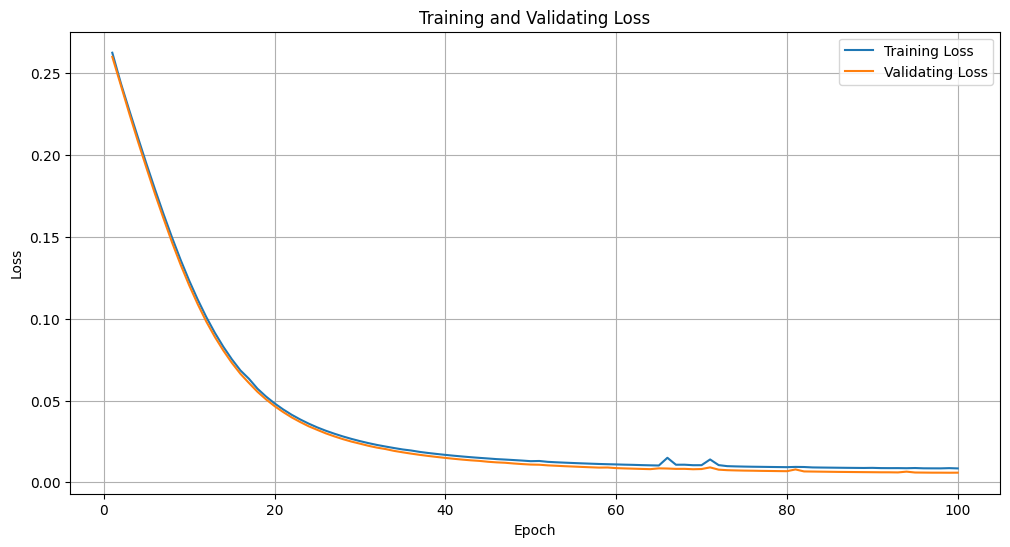

In [ ]:
%run tf_helpers.py 
plot_loss(train_loss, val_loss, p.epochs)

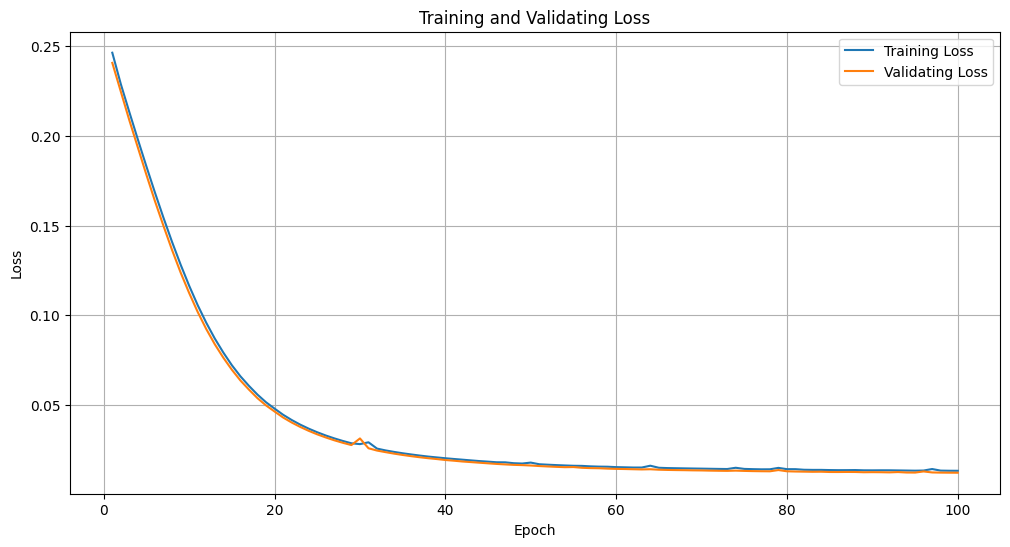

In [ ]:
plot_loss(train_loss, val_loss, p.epochs, p.lr, train_time, p.E_layer, p.d_model)

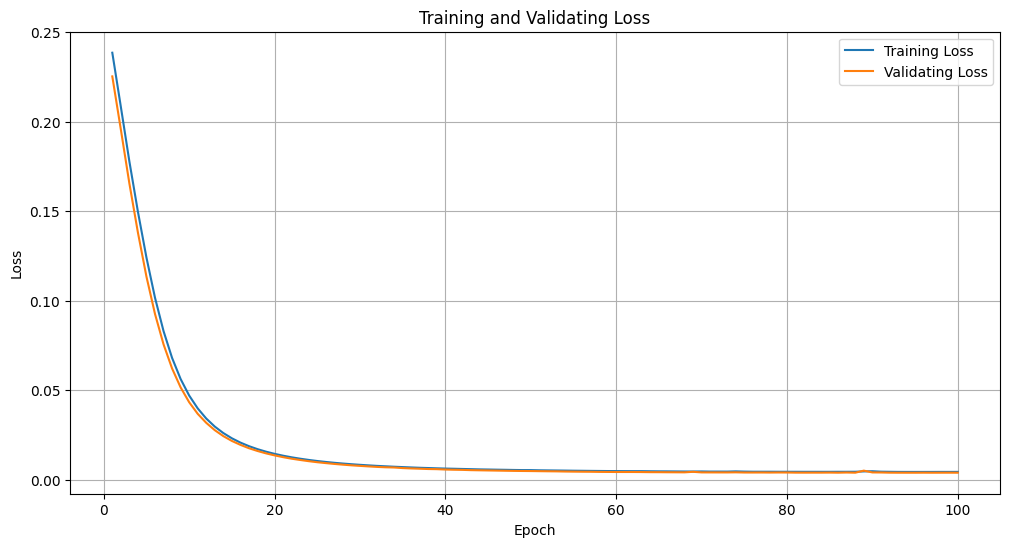

In [ ]:
%run tf_helpers.py 
%run tf_attention.py

#  batch_size = 4
# gradient_accumulation_steps = 4
# device = 'gpu'
# input_dim = 7
# output_dim = 3
# d_model = 512
# heads = 8
# E_layer = 8 
# D_layer = 1 
# epochs = 100
# lr = 0.001
# dropout = 0.5 # for dense layer
# mha_dropout = 0.1 # multihead attention dropout
# l2_reg = 1e-4 # for kernel_regularizer
# loss_fn = MeanSquaredError()
# Val loss: 0.004
plot_loss(train_loss, val_loss, p.epochs, p.lr, train_time, p.E_layer, p.d_model)

MSE: 47328.6562, RMSE: 217.5515, MAE: 47.9207


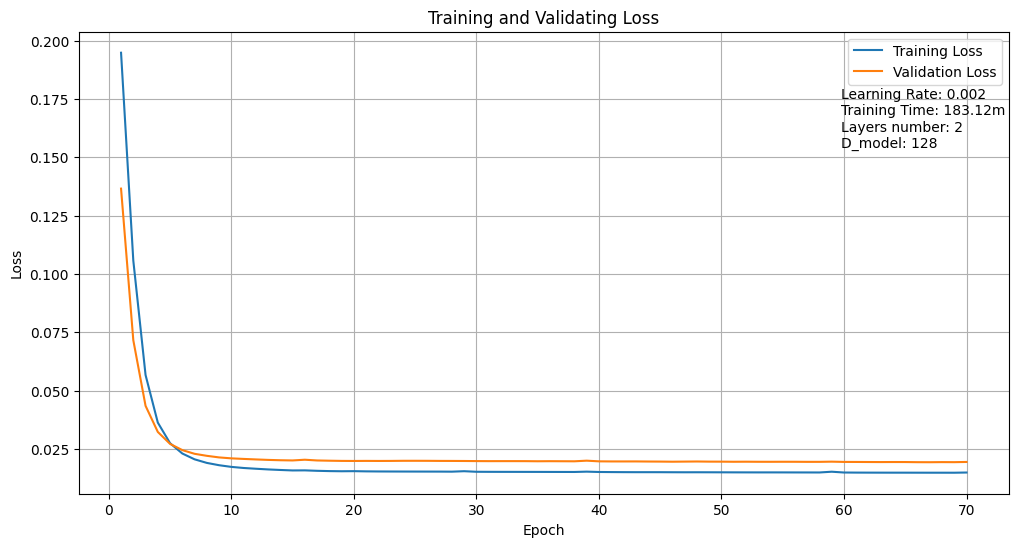

In [ ]:
# Apply scaler, 8 heads
#  batch_size = 8, datasize = 7000, dropout 0.5
mse, rmse, mae, mape = evaluate_model(trained_model, test_data_loader, scalers, param.device)
print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

plot_loss(train_loss, val_loss, param.epochs, param.lr, train_time, param.N, param.d_model)

Test RMSE: 0.0932, Test MAE: 0.0132, Test MAPE: 177268.4062


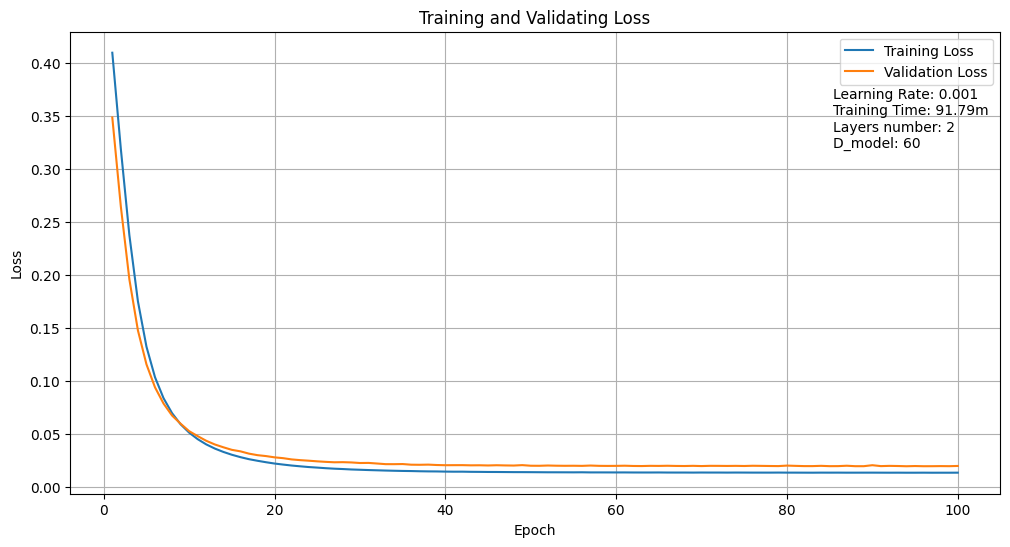

In [ ]:
%run tf_attention.py
%run Parameters.py
param = Params()

# 6 heads
rmse, mae, mape = evaluate_model(model, test_data_loader, param.device)
print(f"Test RMSE: {rmse:.4f}, Test MAE: {mae:.4f}, Test MAPE: {mape:.4f}")
plot_loss(train_loss, val_loss, param.epochs, param.lr, train_time, param.N, param.d_model)

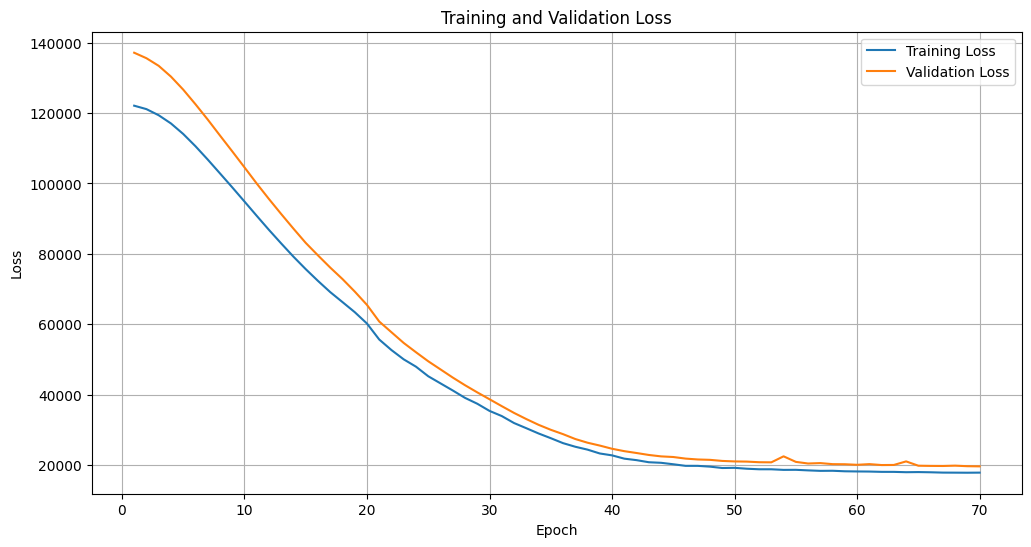

In [ ]:
# 1st try, 70 epochs, lr 0.002, d-model 128, N 2
plot_loss(train_loss, val_loss, epochs)